In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36514")
client

Client Scheduler: tcp://127.0.0.1:36514 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 13 Cores: 65 Memory: 275.16 GB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
from fastjmd95 import rho as densjmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50

Dsig = 30
nlayers = 60
siglayers = np.linspace(20,50,nlayers)
func = interp1d(range(1,nlayers+1), siglayers, fill_value='extrapolate')
sigp1layers = func(np.arange(.5,nlayers+1.5,1))

In [6]:
xchunk = 200
ychunk = 200
sigchunk = 10
membchunk = 1
year = 1963
dnf = 2160
nremap = 60

In [7]:
for itime in range(943920,943920+dnf,dnf):
    
    for nmemb in range(24,36):     
        if nmemb == 24:
            ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (nmemb,year)), 
                                 grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                 prefix=['diag_ocnSnap'], 
                                 delta_t=2e2, iters=itime, 
                                 chunks={'XC':xchunk,'XG':xchunk}
                                ).isel(time=-1)
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,
                                                        'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                        % (nmemb,year)), 
                                                grid_dir=op.join(ddir,
                                                                 'grid_chaO/gridMIT_update1/'),
                                                prefix=['diag_ocnSnap'], 
                                                delta_t=2e2, iters=itime, 
                                                chunks={'XC':xchunk,'XG':xchunk}
                                               ).isel(time=-1)],
                            dim='nmemb')
            
        
    
#################################
    start = time.time()
    utils = xr.apply_ufunc(jmd95.densjmd95, 
                           ds.SALT.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                           ds.THETA.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)),
                           -grav*ds.Z*rhoConst*1e-4, # pressure in [dbar]!!!!
                           dask='parallelized', output_dtypes=[float,]
                          ).where(ds.maskC!=0.).compute()
    
    end = time.time()
    print("MITgcmutils:", end-start)
######################    
    start = time.time()
    xgcm = xr.apply_ufunc(densjmd95, 
                          ds.SALT.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)), 
                          ds.THETA.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)),
                          -grav*ds.Z*rhoConst*1e-4, # pressure in [dbar]!!!!
                          dask='parallelized', output_dtypes=[float,]
                         ).where(ds.maskC!=0.).compute()
    
    end = time.time()
    print("Numba:", end-start)
    
    print(itime)

MITgcmutils: 104.2143452167511
Numba: 82.5756151676178
943920


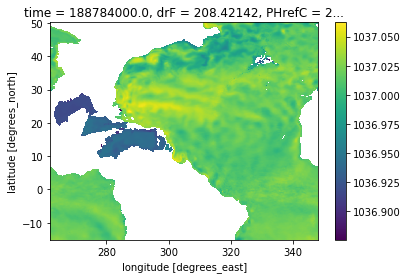

In [11]:
utils.isel(nmemb=0).sel(Z=-2000,method='nearest').plot()

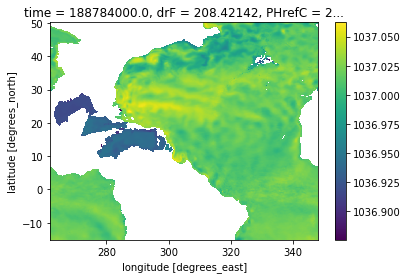

In [12]:
xgcm.isel(nmemb=0).sel(Z=-2000,method='nearest').plot()

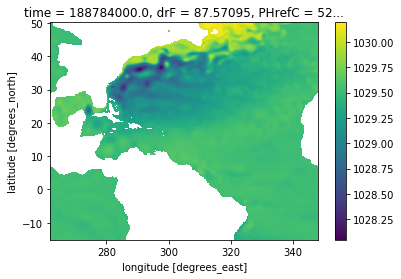

In [14]:
utils.isel(nmemb=0).sel(Z=-500,method='nearest').plot()

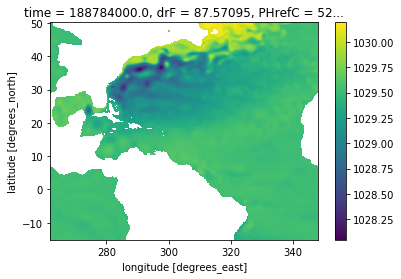

In [15]:
xgcm.isel(nmemb=0).sel(Z=-500,method='nearest').plot()

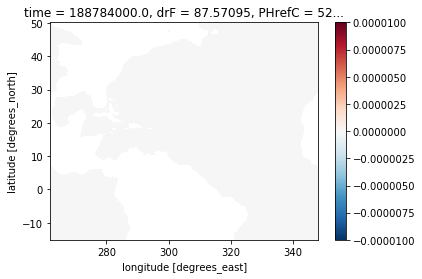

In [17]:
(xgcm-utils).isel(nmemb=0).sel(Z=-500,method='nearest').plot(vmax=1e-5, vmin=-1e-5, 
                                                             cmap='RdBu_r')